In [1]:
import copy

from utils.preprocessing import BasicPreprocessPipeline
from scipy.stats import iqr
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import norm

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
df_test = BasicPreprocessPipeline.run(pd.read_csv('data/sales_ads_test.csv'))
df_train = BasicPreprocessPipeline.run(pd.read_csv('data/sales_ads_train.csv'))
df_data = pd.concat((df_train, df_test), ignore_index=True, copy=True).reset_index()
len(df_test), len(df_train)

Log: Date range : 2021-01-04 00:00:00, 2021-12-04 00:00:00
Log: Preprocessing currency did not found `Cena` column. Skipping.
Log: Date range : 2021-01-05 00:00:00, 2021-12-04 00:00:00
Log: Amount of samples with foreign currency  : 165


(72907, 135397)

## Price investigation
Analysing the distribution of price.

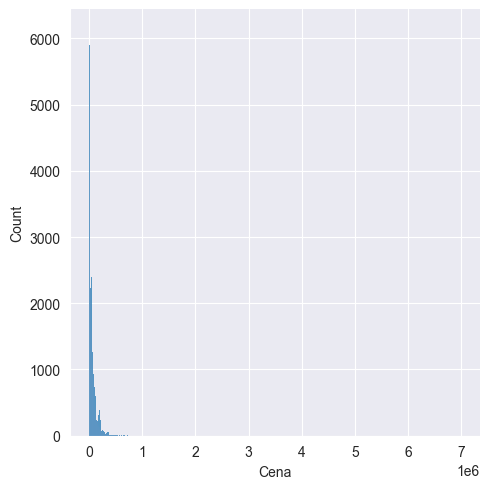

Median : 35900.0
Quantile 90% : 144000.0
Top 10 : [6999000.  6298670.1 2583000.  2370000.  2300000.  2101970.  2100000.
 1950000.  1904040.  1862200. ]


In [4]:
# Distribution of the price
plt.show(sns.displot(df_train.Cena))
print(f"Median : {df_train.Cena.quantile(0.5)}")
print(f"Quantile 90% : {df_train.Cena.quantile(0.9)}")
print(f"Top 10 : {df_train.Cena.sort_values(ascending=False).head(10).to_numpy()}")

In [5]:
display(df_train.sort_values('Cena', ascending=False).head(2))  # The most severe ones
print(f"Average McLaren price : {df_train.groupby('Marka_pojazdu').agg({'Cena': 'mean'}).loc['McLaren', 'Cena']}")

,ID,Cena,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Generacja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Rodzaj_paliwa,Emisja_CO2,Naped,Skrzynia_biegow,Typ_nadwozia,Liczba_drzwi,Kolor,Kraj_pochodzenia,Pierwszy_wlasciciel,Data_pierwszej_rejestracji,Data_publikacji_oferty,Lokalizacja_oferty,Wyposazenie,Wiek_oferty
28851,28852,6999000.0,PLN,Used,BMW,X3,NaN,NaN,2014.0,238000.0,190.0,2000.0,Diesel,NaN,4x4 (permanent),Automatic,SUV,5.0,silver,NaN,NaN,NaN,2021-04-05,"ŁYSKOWSKIEGO, 55B - 86-300 Grudziądz, Kujawsko...","[ABS, Central locking, Electric rear windows, ...",243.0
131997,131998,6298670.1,EUR,New,McLaren,720S Coupe,Standard,NaN,2020.0,1.0,730.0,3994.0,Gasoline,249.0,Rear wheels,Automatic,NaN,2.0,black,NaN,NaN,NaN,2021-04-30,"PS DAmunt 7 - 08024 Madrid, Comunidad de Madri...",[],218.0


Average McLaren price : 1464337.94375


In [6]:
df_train.drop(df_train[df_train.Cena == 6999000.0].index, inplace=True)  # Such BMW seems like an anomaly
df_data.drop(df_data[df_data.Cena == 6999000.0].index, inplace=True)  # Such BMW seems like an anomaly

Amount of outliers 3-sigma rule : 292
Outliers extremes : 585.0, 6298670.1
Outliers ~3 sigma range : 699900.0 1999.0
Outliers ~4 sigma range : 1399915.1250000023 1000.0


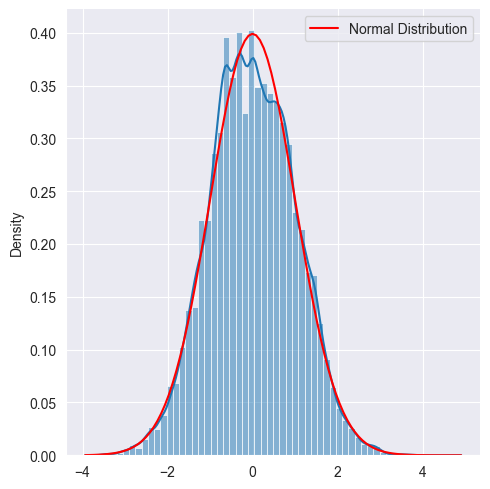

In [7]:
x = df_train.Cena.to_numpy()
x = np.log(x)
x = (x - x.mean()) / (x.std())
sns.displot(x, kde=True, stat="density", bins=60)
normal = np.linspace(min(x), max(x), 100)
y = norm.pdf(normal, 0, 1)
plt.plot(normal, y, 'r-', label='Normal Distribution')
outliers = x[(x < -3) | (x > 3)]
print(f"Amount of outliers 3-sigma rule : {len(outliers)}")
print(f"Outliers extremes : {df_train.Cena[(x < -3) | (x > 3)].min()}, {df_train.Cena[(x < -3) | (x > 3)].max()}")
print(f"Outliers ~3 sigma range : {df_train.Cena.quantile(0.9975)} {df_train.Cena.quantile(0.0025)}")
print(f"Outliers ~4 sigma range : {df_train.Cena.quantile(0.99975)} {df_train.Cena.quantile(0.00025)}")
plt.legend()
plt.show()

In [8]:
df_train['Cena_log'] = df_train.Cena.apply(np.log)
df_data['Cena_log'] = df_data.Cena.to_numpy()
df_data.loc[~df_data['Cena_log'].isna(), 'Cena_log'] = df_train['Cena_log']

Notes are that data is very skewed to the left. There are a few extreme target outliers, 
which will be hard to tackle during prediction (probable premium car brands).
Since top 2 cars are 3 times more expensive than the rest most expensive cars, they should
be excluded. They are too big of an outlier. Without augmentation it would be extremely hard
to take them into account. <br/><br/>
Therefore, a log can be applied as data show patterns of exponential growth typical for sales data. After log
transformation it can be seen that the data was in fact exponentially distributed. Furthermore, according to
3-sigma rule we can identify values, which would be hard targets for the model as they fall into extreme
regions of the normal distribution. This gives us total of 219 such samples.

## Horse power inverstigation
Analysing the correlation between horsepower and other features. Tracking anomalies
based on plots and logical real worlds assumptions (small engine can't have high power etc.)

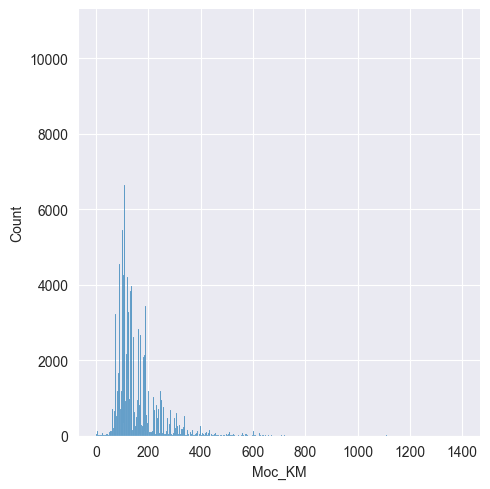

Top 10 horse power : [1398.0, 1236.0, 1203.0, 1111.0, 1111.0]
Top 10 horse power (Test) : [1398.0, 1300.0, 1236.0, 1115.0, 1000.0]
Top 10 horse power (Brands) : ['Volkswagen', 'Bentley', 'Renault', 'Ford', 'Buick']


In [9]:
plt.show(sns.displot(df_train.Moc_KM))
print(f"Top 10 horse power : {df_train.Moc_KM.sort_values(ascending=False).head(5).to_list()}")
print(f"Top 10 horse power (Test) : {df_test.Moc_KM.sort_values(ascending=False).head(5).to_list()}")
print(f"Top 10 horse power (Brands) : {df_train.sort_values('Moc_KM', ascending=False).Marka_pojazdu.head(5).to_list()}")

,ID,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Generacja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Rodzaj_paliwa,Emisja_CO2,Naped,Skrzynia_biegow,Typ_nadwozia,Liczba_drzwi,Kolor,Kraj_pochodzenia,Pierwszy_wlasciciel,Data_pierwszej_rejestracji,Data_publikacji_oferty,Lokalizacja_oferty,Wyposazenie,Wiek_oferty
50072,50073,PLN,Used,Chevrolet,Volt,NaN,NaN,2016,44600.0,1398.0,NaN,Electric,NaN,NaN,Automatic,sedan,5.0,red,United States,NaN,01/01/2017,2021-04-27,"Bezrzecze, gm. Dobra (Szczecińska), policki, Z...","[ABS, Electrically adjustable mirrors, Passeng...",221.0
46536,46537,PLN,Used,Suzuki,Grand Vitara,NaN,II (2005-2014),2007,212000.0,1300.0,1997.0,Diesel,NaN,4x4 (attached manually),Manual,SUV,5.0,black,NaN,NaN,NaN,2021-04-25,"Biała Podlaska, Lubelskie","[ABS, Electric front windows, Drivers airbag, ...",223.0
48987,48988,PLN,Used,Bentley,Other,NaN,NaN,1970,77000.0,1236.0,6700.0,Gasoline,NaN,NaN,Automatic,sedan,4.0,other,NaN,NaN,NaN,2021-01-05,"Starogard Gdański, starogardzki, Pomorskie","[ABS, Power steering, Leather upholstery, Elec...",333.0
9106,9107,PLN,Used,Volkswagen,Bora,NaN,NaN,2001,215000.0,1115.0,1994.0,Gasoline + LPG,NaN,Front wheels,Manual,sedan,4.0,blue,Germany,NaN,NaN,2021-04-05,"Wrocław, Dolnośląskie, Fabryczna","[ABS, Electrochromic rear view mirror, Electri...",243.0
20991,20992,PLN,Used,Renault,Megane,NaN,III (2008-2016),2010,145566.0,1000.0,1598.0,Gasoline,NaN,Front wheels,Manual,city_cars,5.0,gray,NaN,Yes,NaN,2021-02-05,"Koscielniaka 113 - 41-409 Mysłowice, Śląskie (...","[ABS, Electric front windows, On-board compute...",302.0


,ID,Cena,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Generacja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Rodzaj_paliwa,Emisja_CO2,Naped,Skrzynia_biegow,Typ_nadwozia,Liczba_drzwi,Kolor,Kraj_pochodzenia,Pierwszy_wlasciciel,Data_pierwszej_rejestracji,Data_publikacji_oferty,Lokalizacja_oferty,Wyposazenie,Wiek_oferty,Cena_log
132975,132976,190199.0,PLN,New,Volkswagen,Passat,NaN,B8 (2014-),2021.0,1.0,1398.0,NaN,Hybrid,NaN,Front wheels,Automatic,sedan,5.0,black,NaN,NaN,NaN,2021-04-30,"ul. Radzymińska 78 - 03-752 Warszawa, Praga-Pó...","[ABS, Twilight sensor, Isofix, On-board comput...",218.0,12.155826
86447,86448,55900.0,NaN,Used,Bentley,Other,NaN,NaN,NaN,77000.0,1236.0,6700.0,Gasoline,NaN,NaN,Automatic,sedan,4.0,other,NaN,NaN,NaN,2021-01-05,"Starogard Gdański, starogardzki, Pomorskie","[ABS, Power steering, Leather upholstery, Elec...",333.0,10.931320
124210,124211,6600.0,PLN,Used,Renault,Espace,NaN,NaN,2007.0,191874.0,1203.0,1900.0,Diesel,NaN,Front wheels,Manual,minivan,5.0,blue,NaN,Yes,NaN,2021-04-26,"Staszica 2 - 64-030 Śmigiel, kościański, Wielk...","[ABS, CD, Twilight sensor, ESP(stabilization o...",222.0,8.794825
14341,14342,49000.0,PLN,Used,Ford,Ranchero,NaN,NaN,1979.0,1111.0,1111.0,1111.0,Gasoline,NaN,NaN,Automatic,station_wagon,2.0,red,NaN,NaN,NaN,2021-04-29,"Kazimierza Wlk 102 - 32-300 Olkusz, olkuski, M...",[],219.0,10.799576
36292,36293,57000.0,PLN,NaN,Buick,Other,NaN,NaN,1957.0,11111.0,1111.0,1111.0,Gasoline,NaN,NaN,Automatic,city_cars,2.0,black,United States,NaN,NaN,2021-04-29,"Kazimierza Wlk 102 - 32-300 Olkusz, olkuski, M...",[],219.0,10.950807


IQR based range 6.0 : 270.0


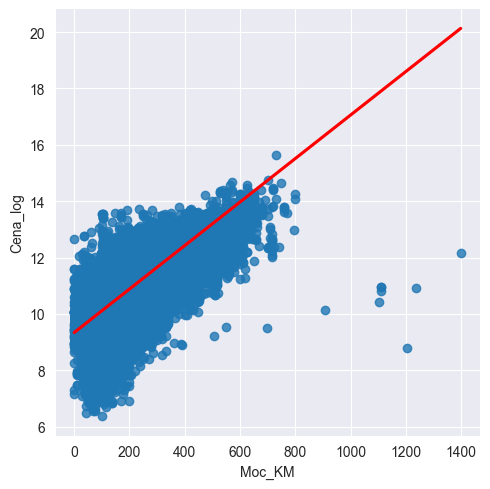

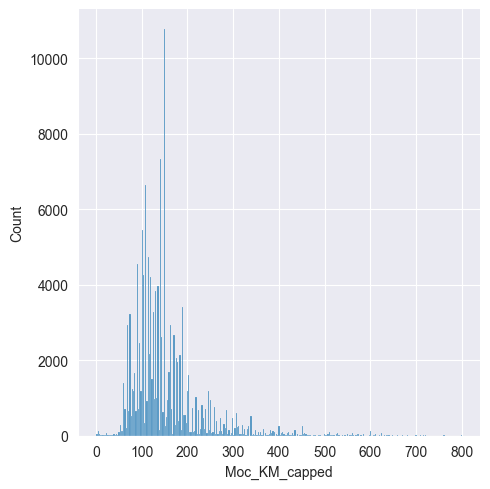

In [10]:
display(df_test.sort_values('Moc_KM', ascending=False).head(5))
display(df_train.sort_values('Moc_KM', ascending=False).head(5))
print(f"IQR based range {df_test.Moc_KM.quantile(0.25) - 1.5 * iqr(df_test.Moc_KM.values, nan_policy='omit')} : {df_test.Moc_KM.quantile(0.75) + 1.5 * iqr(df_test.Moc_KM.values, nan_policy='omit')}")
sns.lmplot(x="Moc_KM", y="Cena_log", data=df_train, ci=None, line_kws={'color': 'red'})
df_train.loc[:, 'Moc_KM_capped'] = df_train.Moc_KM.to_numpy()
df_train.loc[df_train.Moc_KM > 800, 'Moc_KM_capped'] = 800
plt.show(sns.displot(df_train.Moc_KM_capped))
df_train.drop(columns='Moc_KM_capped', inplace=True)

There are Suzuki and Passat with extreme horsepower values, which suggests some potential anomalies.
To fix them the approach would be
capping the value based on the standard deviation and mean of `Moc_KM` for each `Marka_pojazdu`. This could
help as it is also applicable for the testing set.
Furthermore, engine volume (`Pojemnocs_cm`) in real world has high correlation with power. Therefore, it could be used for
detecting outliers. Here a simple linear regression line should discover some anomalies.
<br/><br/>
Anyway, it can be seen that correlation between price and power exists, but it is messy.

Value threshold : 100 - (0.04801%)
Second value threshold : 10 - (0.00480%)


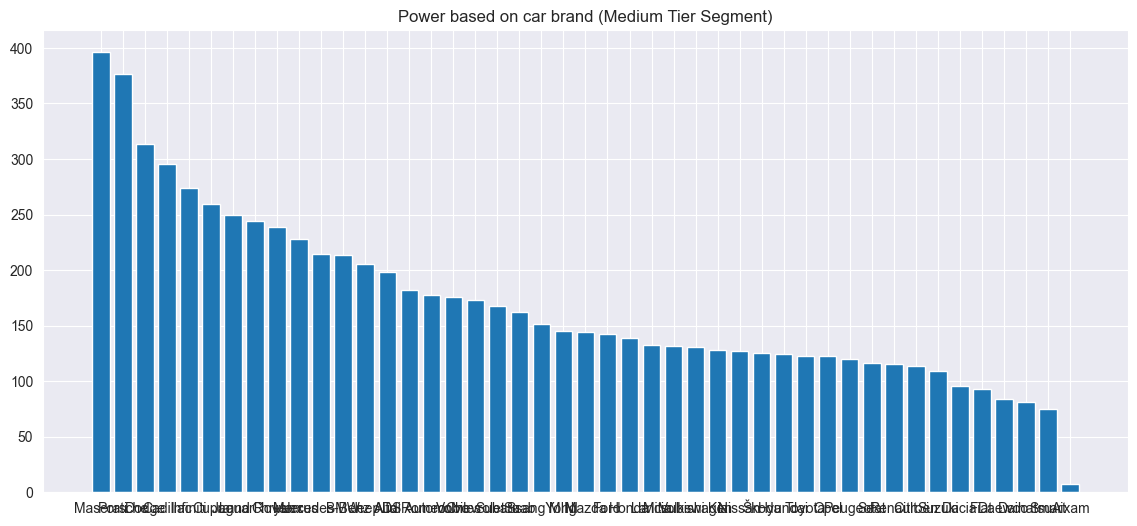

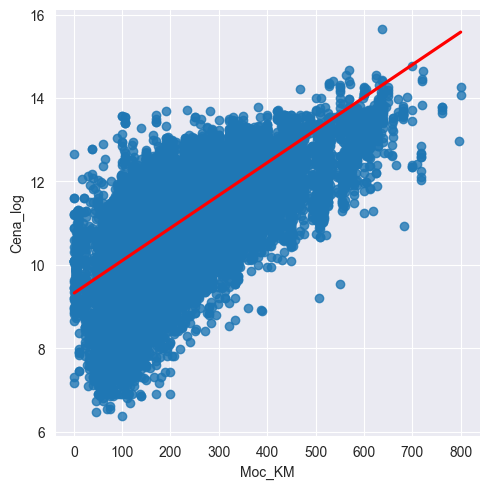

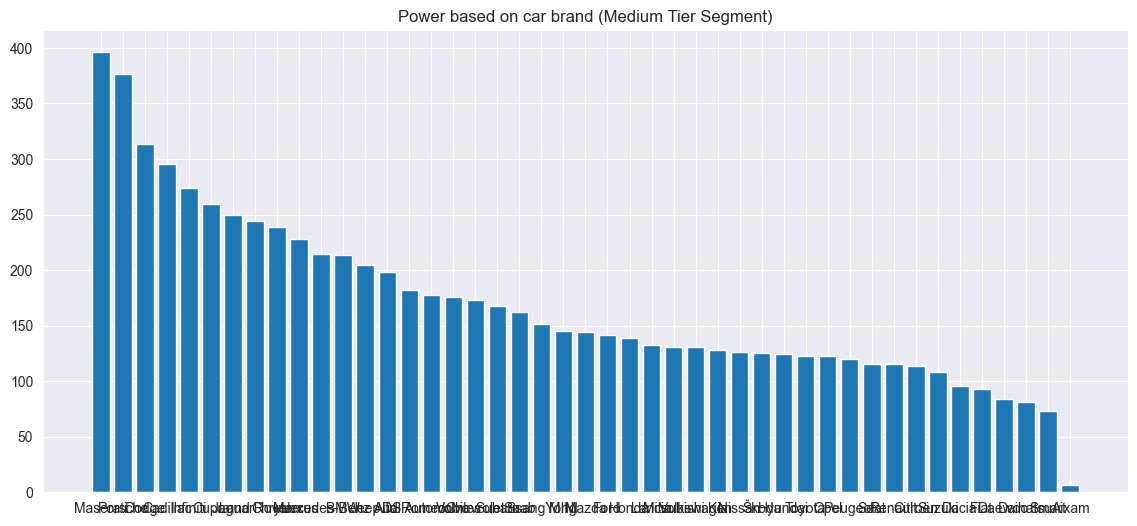

Capped total of 416 samples, which is 0.1997%


In [11]:
value_threshold = 100
value_second_threshold = 10
sigma_scalar = 5
print(f"Value threshold : {value_threshold} - ({value_threshold / len(df_data) * 100:.5f}%)")
print(f"Second value threshold : {value_second_threshold} - ({value_second_threshold / len(df_data) * 100:.5f}%)")

funcs = ('mean', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.5), lambda x: x.quantile(0.75))
power_table = ((df_data.groupby('Marka_pojazdu').agg({'Moc_KM': funcs}))
               .sort_values(('Moc_KM', 'mean'), ascending=False))
power_table.columns = ('mean', 'std', 'Q1', 'Q2', 'Q3')

value_counts = df_data.Marka_pojazdu.value_counts()[power_table.index]
plt.figure(figsize=(14, 6))
common_brands = power_table[value_counts >= value_threshold]
plt.bar(common_brands.index, common_brands.loc[:, 'mean'])
plt.title('Power based on car brand (Medium Tier Segment)')
plt.show()

ceiling = common_brands.loc[:, 'mean'] + common_brands.loc[:, 'std'] * sigma_scalar
def cap_power_based_on_brand(row: pd.Series):
    row = row.copy()
    if row.Marka_pojazdu not in common_brands.index:
        return row
    if row.Moc_KM > ceiling[row.Marka_pojazdu]:
        row.Moc_KM = ceiling[row.Marka_pojazdu]
    return row
df_data_capped = df_data.loc[:, ['Moc_KM', 'Marka_pojazdu', 'Cena_log']].apply(cap_power_based_on_brand, axis=1)

uncommon_brands = power_table[(value_counts < value_threshold) & (value_counts >= value_second_threshold)]
IQR = uncommon_brands.loc[:, 'Q3'] - uncommon_brands.loc[:, 'Q1']
ceiling = uncommon_brands.loc[:, 'Q2'] + 1.5 * IQR
floor = uncommon_brands.loc[:, 'Q2'] - 1.5 * IQR
def cap_power_based_on_brand(row: pd.Series):
    row = row.copy()
    if row.Marka_pojazdu not in uncommon_brands.index:
        return row
    if row.Moc_KM > ceiling[row.Marka_pojazdu]:
        row.Moc_KM = ceiling[row.Marka_pojazdu]
    elif row.Moc_KM < floor[row.Marka_pojazdu]:
        row.Moc_KM = floor[row.Marka_pojazdu]
    return row
df_data_capped = df_data_capped.apply(cap_power_based_on_brand, axis=1)
sns.lmplot(x="Moc_KM", y="Cena_log", data=df_data_capped, ci=None, line_kws={'color': 'red'})

power_table = df_data_capped.groupby('Marka_pojazdu').agg({'Moc_KM': ('mean', 'std')}).sort_values(('Moc_KM', 'mean'), ascending=False)
value_counts = df_data_capped.Marka_pojazdu.value_counts()[power_table.index]
plt.figure(figsize=(14, 6))
common_brands = power_table[value_counts >= value_threshold]
plt.bar(common_brands.index, common_brands.loc[:, ('Moc_KM', 'mean')])
plt.title('Power based on car brand (Medium Tier Segment)')
plt.show()

df_data.loc[:, 'Moc_KM_brand_capped'] = df_data_capped.Moc_KM.to_numpy()
total_capped = (df_data.Moc_KM != df_data.Moc_KM_brand_capped)[~df_data.Moc_KM.isna()].sum()
print(f"Capped total of {total_capped} samples, which is {total_capped / len(df_data) * 100:.4f}%")

Here values were clipped based on the average horsepower per brand category. Categories with high amount of
samples were treated with 3-sigma rule to take into account variance of the data, whereas small samples
were filtered by IQR due to unreliable standard deviation.

In [12]:
# Manual checking for potential problems and ideas
df_data_capped.sort_values('Moc_KM', ascending=False).head(2)
display(df_data_capped.sort_values('Moc_KM', ascending=False).head(15))

,Moc_KM,Marka_pojazdu,Cena_log
149804,885.000000,Dodge,NaN
81809,800.000000,Ferrari,14.265949
86143,800.000000,Ferrari,14.077105
16242,797.000000,Dodge,12.971530
148343,774.000000,Dodge,NaN
185469,771.077185,Chevrolet,NaN
6562,761.000000,Porsche,13.628869
160534,761.000000,Porsche,NaN
6693,761.000000,Porsche,13.781970
138255,761.000000,Porsche,NaN


Additionally, the engine volume can be taken into account. Notice, that although high volume engines can have
low power due to low rpm limit, inefficient burning and so on, the small volume engines are very hard to
improve on power. Therefore, the outliers below regression line should be taken into account.<br/><br/>
Keep in mind the volume may also have outliers! Furthermore, in this case horsepower outliers were managed
by the categories (with logical assumptions that categories has strong influence on the horsepower). Thus,
it is more probable that the engine volume contains outliers rather than horsepower.

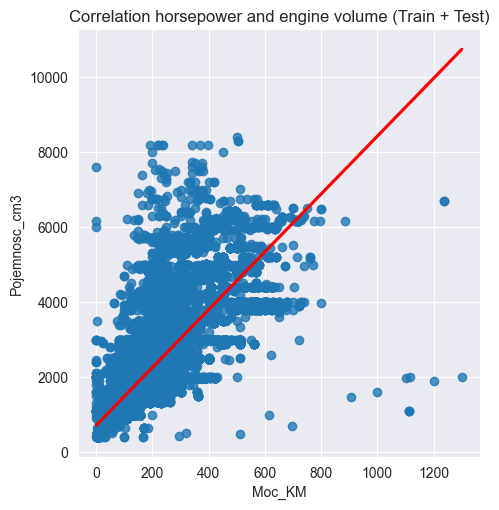

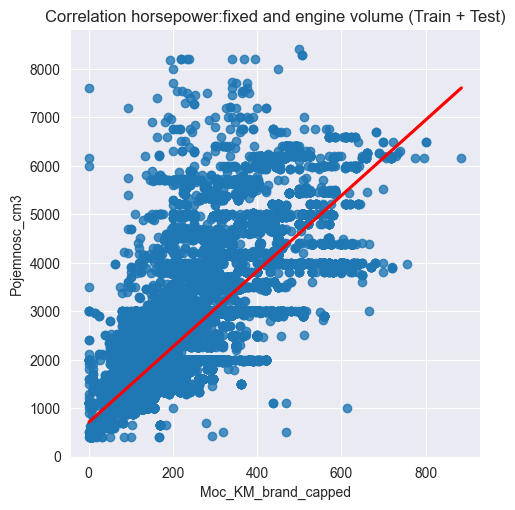

In [13]:
sns.lmplot(x="Moc_KM", y="Pojemnosc_cm3", data=df_data, ci=None, line_kws={'color': 'red'})
plt.title("Correlation horsepower and engine volume (Train + Test)")
plt.show()
sns.lmplot(x="Moc_KM_brand_capped", y="Pojemnosc_cm3", data=df_data, ci=None, line_kws={'color': 'red'})
plt.title("Correlation horsepower:fixed and engine volume (Train + Test)")
plt.show()

Funny horizontal line patterns on the plot are due to often engines fixed volume, which can have
various power based on compression, turbo etc.

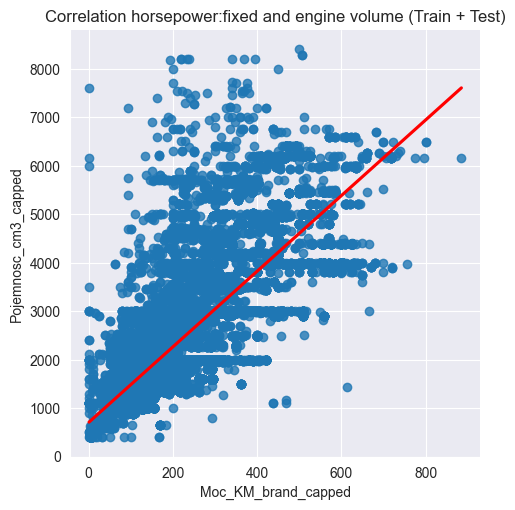

,index,ID,Cena,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Generacja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Rodzaj_paliwa,Emisja_CO2,Naped,Skrzynia_biegow,Typ_nadwozia,Liczba_drzwi,Kolor,Kraj_pochodzenia,Pierwszy_wlasciciel,Data_pierwszej_rejestracji,Data_publikacji_oferty,Lokalizacja_oferty,Wyposazenie,Wiek_oferty,Cena_log,Moc_KM_brand_capped,Pojemnosc_cm3_capped
7977,7977,7978,55000.0,PLN,Used,Mercedes-Benz,SL,NaN,R129 (1989-2000),1999.0,231108.0,320.0,500.0,Gasoline,NaN,Rear wheels,Automatic,convertible,2.0,black,NaN,NaN,NaN,2021-04-30,"Warszawa, Mazowieckie, Żoliborz","[ABS, Electric front windows, Drivers airbag, ...",218.0,10.915088,320.000000,1264.457220
24437,24437,24438,13500.0,PLN,Used,Smart,NaN,NaN,NaN,2003.0,112000.0,698.0,698.0,Gasoline,NaN,Rear wheels,Automatic,small_cars,2.0,black,NaN,NaN,09/09/2020,2021-04-29,"Gdańsk, Pomorskie, Śródmieście",[],219.0,9.510445,278.588279,1363.457220
58714,58714,58715,359221.0,PLN,Used,Tesla,Model X,NaN,NaN,NaN,62835.0,613.0,1000.0,Diesel,NaN,4x4 (attached automatically),Automatic,city_cars,5.0,black,NaN,NaN,NaN,2021-04-05,"LIPOWA 2 - 55-300 Komorniki, średzki, Dolnoślą...","[ABS, Passengers airbag, Central locking, Driv...",243.0,12.791693,613.000000,1436.463805
144019,144019,8623,NaN,PLN,Used,Ford,Mustang,NaN,NaN,2018.0,4500.0,510.0,498.0,Gasoline,NaN,Rear wheels,Manual,coupe,3.0,yellow,Canada,Yes,05/05/2019,2021-04-24,"Kołobrzeg, kołobrzeski, Zachodniopomorskie","[ABS, Electric front windows, Drivers airbag, ...",224.0,NaN,467.577136,1158.166109
179382,179382,43986,NaN,PLN,Used,Lexus,LS,NaN,III (2000-2006),2001.0,90000.0,294.0,430.0,Gasoline,NaN,Rear wheels,Automatic,sedan,5.0,silver,United States,Yes,03/02/2020,2021-04-24,"Kłodzko, kłodzki, Dolnośląskie","[ABS, Electric front windows, Drivers airbag, ...",224.0,NaN,294.000000,800.493435


In [14]:
error_threshold = -2_001  # Only for significant outliers
volume_threshold = 1_001  # Only for engines smaller than 1 liter (assumption based on car domain knowledge)
volume_min = 1_000
decay_scalar = 0.5  # How much to diminish the total outliers
mask = ~(df_data.Pojemnosc_cm3.isna() | df_data.Moc_KM_brand_capped.isna())
slope, bias = np.polyfit(df_data.Moc_KM_brand_capped[mask].to_numpy(),
                         df_data.Pojemnosc_cm3[mask].to_numpy(), 1)
errors = (df_data.Pojemnosc_cm3[mask].to_numpy() - (bias + slope * df_data.Moc_KM_brand_capped[mask].to_numpy()))
args = np.argwhere((df_data.Pojemnosc_cm3[mask].to_numpy() < volume_threshold) & (errors < error_threshold))
indices = df_data.Moc_KM_brand_capped[mask].index[args.flatten()]

df_data.loc[:, 'Pojemnosc_cm3_capped'] = df_data.Pojemnosc_cm3.to_numpy()
df_data.loc[indices, 'Pojemnosc_cm3_capped'] = (df_data.loc[indices, 'Pojemnosc_cm3_capped'] + bias + slope * df_data.Moc_KM_brand_capped[mask].to_numpy()[indices]) / 2
sns.lmplot(x="Moc_KM_brand_capped", y="Pojemnosc_cm3_capped", data=df_data, ci=None, line_kws={'color': 'red'})
plt.title("Correlation horsepower:fixed and engine volume (Train + Test)")
plt.show()
df_data.loc[indices]

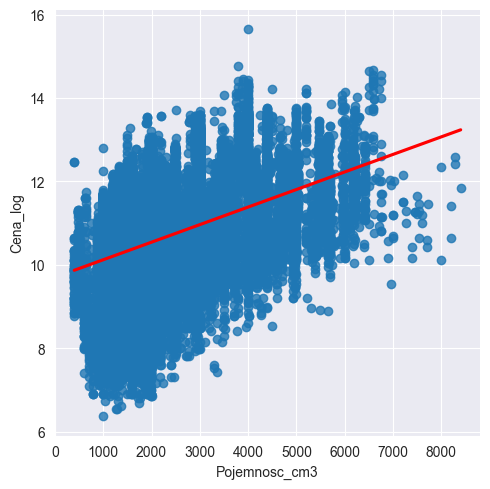

In [15]:
sns.lmplot(x="Pojemnosc_cm3", y="Cena_log", data=df_train, ci=None, line_kws={'color': 'red'})

There are only a few extreme outliers in this small engine volume region. Nontheless, for future more robust
model one fact should be remembered. The electric cars like Tesla shoud have their engine volume deleted or
be marked as electric.

Top 10 mileage : [1111111111.0, 500000000.0, 500000000.0, 206549168.0, 99999999.0]
Top 10 mileage (Test): [1111111111.0, 500000000.0, 500000000.0, 206549168.0, 99999999.0]
Top 10 mileage : [1111111111.0, 500000000.0, 500000000.0, 206549168.0, 99999999.0]
Quantile 90% mileage : 260000.0
IQR based range -176500.0 : 435500.0
Amount of IQR outliers : 586
Duplicates after clipping : 587


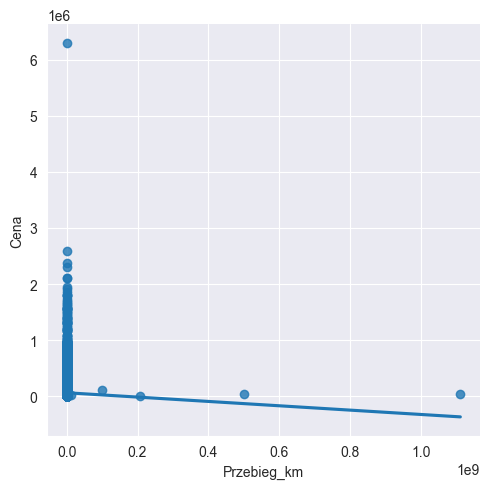

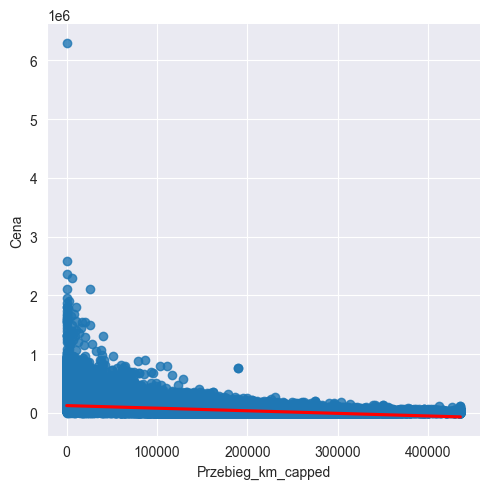

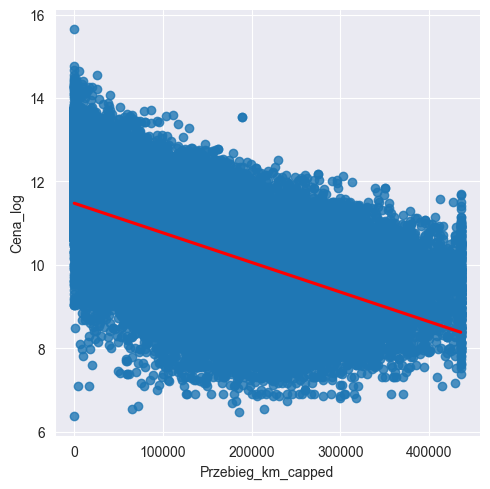

In [16]:
print(f"Top 10 mileage : {df_data.Przebieg_km.sort_values(ascending=False).head(5).to_list()}")
print(f"Top 10 mileage (Test): {df_data.Przebieg_km.sort_values(ascending=False).head(5).to_list()}")
print(f"Top 10 mileage : {df_data.sort_values('Przebieg_km', ascending=False).Przebieg_km.head(5).to_list()}")
print(f"Quantile 90% mileage : {df_data.Przebieg_km.quantile(0.9)}")
print(f"IQR based range {df_data.Przebieg_km.quantile(0.25) - 1.5 * iqr(df_data.Przebieg_km.to_numpy(), nan_policy='omit')} : {df_data.Przebieg_km.quantile(0.75) + 1.5 * iqr(df_data.Przebieg_km.to_numpy(), nan_policy='omit')}")
max_value = df_data.Przebieg_km.quantile(0.75) + 1.5 * iqr(df_data.Przebieg_km.to_numpy(), nan_policy='omit')
super_max_value = df_data.Przebieg_km.quantile(0.75) + 5.0 * iqr(df_data.Przebieg_km.to_numpy(), nan_policy='omit')
print(f"Amount of IQR outliers : {df_data[df_data.Przebieg_km > max_value].shape[0]}")
sns.lmplot(x="Przebieg_km", y="Cena", data=df_data, ci=None)  # Ci will look ridiculous here


df_data.loc[:, 'Przebieg_km_capped'] = df_data.Przebieg_km.to_numpy()
df_data.loc[df_data.Przebieg_km > max_value, 'Przebieg_km_capped'] = max_value
df_data.loc[:, 'Przebieg_km_cleared'] = df_data.Przebieg_km.to_numpy()
df_data.loc[df_data.Przebieg_km > super_max_value, 'Przebieg_km_cleared'] = np.nan
sns.lmplot(x="Przebieg_km_capped", y="Cena", data=df_data, ci=None, line_kws={'color': 'red'})
sns.lmplot(x="Przebieg_km_capped", y="Cena_log", data=df_data, ci=None, line_kws={'color': 'red'})
print(f"Duplicates after clipping : {(df_data.Przebieg_km_capped == max_value).sum()}")
plt.show()

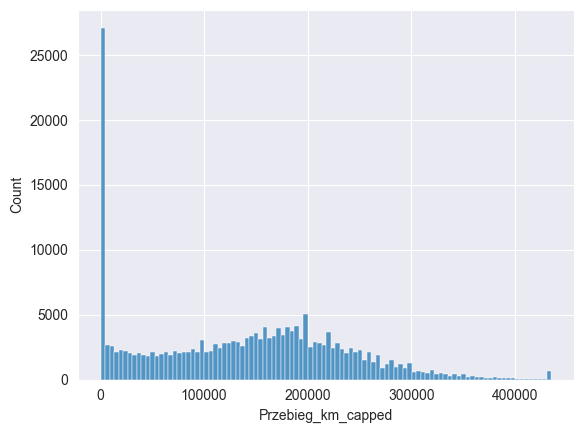

In [17]:
sns.histplot(x="Przebieg_km_capped", data=df_data, bins=100)
plt.show()

Here, on the other hand cutting the mileage based on the IQR might work. It can be seen that outliers are so big
that is hard to see the correlation. After capping the value correlation is much clearer and it can be seen
that for larger values of mileage it is decent.<br/></br>
Nonetheless, it will not help with small values.

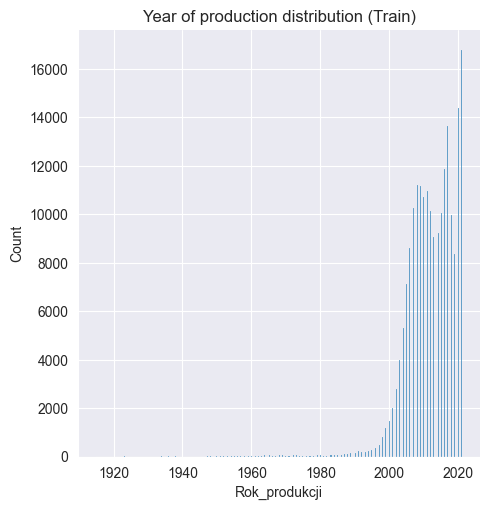

Top 10 age : [1915.0, 1915.0, 1922.0, 1922.0, 1923.0]
Oldest 10 age brands : 


,index,ID,Cena,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Generacja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Rodzaj_paliwa,Emisja_CO2,Naped,Skrzynia_biegow,Typ_nadwozia,Liczba_drzwi,Kolor,Kraj_pochodzenia,Pierwszy_wlasciciel,Data_pierwszej_rejestracji,Data_publikacji_oferty,Lokalizacja_oferty,Wyposazenie,Wiek_oferty,Cena_log,Moc_KM_brand_capped,Pojemnosc_cm3_capped,Przebieg_km_capped,Przebieg_km_cleared
183449,183449,48053,NaN,PLN,Used,Ford,Other,NaN,NaN,1915.0,5.0,16.0,2960.0,Gasoline,NaN,Rear wheels,Manual,convertible,2.0,black,NaN,NaN,NaN,2021-02-05,"Elbląska - 80-718 Gdańsk, Pomorskie (Polska)",[],302.0,NaN,16.0,2960.0,5.0,5.0
138284,138284,2888,NaN,PLN,Used,Ford,Other,NaN,NaN,1915.0,5.0,16.0,2960.0,Gasoline,NaN,Rear wheels,Manual,convertible,2.0,black,NaN,NaN,NaN,2021-02-05,"Elbląska - 80-718 Gdańsk, Pomorskie (Polska)",[],302.0,NaN,16.0,2960.0,5.0,5.0
161638,161638,26242,NaN,PLN,Used,Chevrolet,Other,NaN,NaN,1922.0,70000.0,50.0,2800.0,Gasoline,NaN,NaN,Manual,convertible,5.0,beige,NaN,Yes,NaN,2021-02-05,transport pod dom Chrzanów szpitalna 84 - 32-5...,[],302.0,NaN,50.0,2800.0,70000.0,70000.0
168324,168324,32928,NaN,PLN,Used,Chevrolet,Other,NaN,NaN,1922.0,70000.0,50.0,2800.0,Gasoline,NaN,NaN,Manual,convertible,5.0,beige,NaN,Yes,NaN,2021-02-05,transport pod dom Chrzanów szpitalna 84 - 32-5...,[],302.0,NaN,50.0,2800.0,70000.0,70000.0
162984,162984,27588,NaN,PLN,Used,Citroën,Other,NaN,NaN,1923.0,1.0,25.0,1452.0,Gasoline,NaN,NaN,Manual,convertible,4.0,blue,NaN,NaN,NaN,2021-04-30,"Ogrodnicza 5-7 - 95-100 Zgierz, zgierski, Łódz...",[],218.0,NaN,25.0,1452.0,1.0,1.0


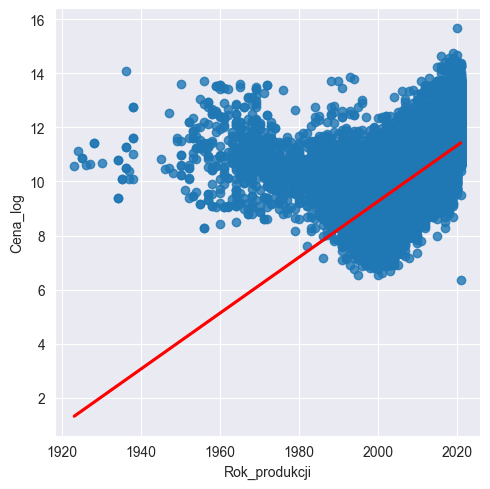

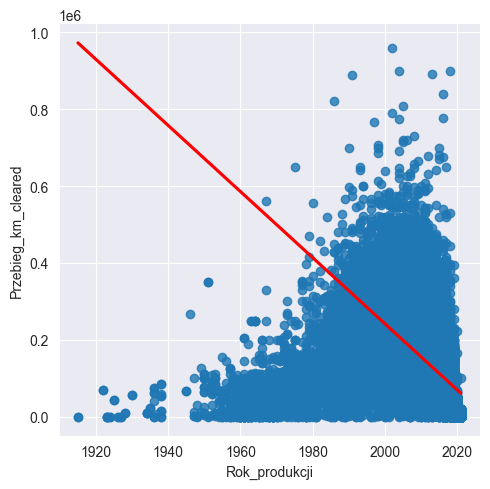

In [18]:
sns.displot(df_data.Rok_produkcji)
plt.title("Year of production distribution (Train)")
plt.show()
print(f"Top 10 age : {df_data.Rok_produkcji.sort_values().head(5).to_list()}")
print("Oldest 10 age brands : ")
display(df_data.sort_values('Rok_produkcji').head(5))

sns.lmplot(x="Rok_produkcji", y="Cena_log", data=df_train, ci=None, line_kws={'color': 'red'})
sns.lmplot(x="Rok_produkcji", y="Przebieg_km_cleared", data=df_data, ci=None, line_kws={'color': 'red'})

## Imputation for numerical features

In [19]:
power_brand_sum = (df_data.Moc_KM.isna() & df_data.Marka_pojazdu.notna()).sum()
power_model_brand_sum = (df_data.Moc_KM.isna() & df_data.Model_pojazdu.isna() & df_data.Marka_pojazdu.notna()).sum()
power_brand_sum, power_model_brand_sum

(3857, 82)

Low ratio above indicates plethora of Horse Power missing data could be filled based on the brand value.

In [20]:
np.random.seed(100)
mask = df_data.Moc_KM.isna() & df_data.Marka_pojazdu.notna()
power = df_data.groupby('Marka_pojazdu').agg({'Moc_KM_brand_capped': ('mean', 'std')})
counts = df_data.Marka_pojazdu.value_counts()
reliable_references = counts.index[counts > 30]

display(df_data.loc[mask, ('Moc_KM_brand_capped', 'Marka_pojazdu')].head(5))
mask = df_data.Marka_pojazdu.isin(reliable_references) & mask
df_data.loc[:, 'Moc_KM_filled'] = df_data.Moc_KM_brand_capped.to_numpy()
df_data.loc[mask, 'Moc_KM_filled'] = df_data.loc[mask, 'Marka_pojazdu'].apply(
    lambda row: (power.loc[row, ('Moc_KM_brand_capped', 'mean')] +
                 np.random.uniform(-0.2, 0.2) * power.loc[row, ('Moc_KM_brand_capped', 'std')])
)
df_data.loc[mask, ('Moc_KM_filled', 'Marka_pojazdu')].head(5)

,Moc_KM_brand_capped,Marka_pojazdu
4,NaN,Toyota
30,NaN,Škoda
201,NaN,Opel
284,NaN,Ford
295,NaN,BMW


,Moc_KM_filled,Marka_pojazdu
4,123.565328,Toyota
30,121.394124,Škoda
201,121.543148,Opel
284,150.818381,Ford
295,195.522271,BMW


In [21]:
df_data.drop(index=df_data.index[df_data.Cena > 6_000_000], inplace=True)

In [22]:
df_data.columns

Index(['index', 'ID', 'Cena', 'Waluta', 'Stan', 'Marka_pojazdu',
       'Model_pojazdu', 'Wersja_pojazdu', 'Generacja_pojazdu', 'Rok_produkcji',
       'Przebieg_km', 'Moc_KM', 'Pojemnosc_cm3', 'Rodzaj_paliwa', 'Emisja_CO2',
       'Naped', 'Skrzynia_biegow', 'Typ_nadwozia', 'Liczba_drzwi', 'Kolor',
       'Kraj_pochodzenia', 'Pierwszy_wlasciciel', 'Data_pierwszej_rejestracji',
       'Data_publikacji_oferty', 'Lokalizacja_oferty', 'Wyposazenie',
       'Wiek_oferty', 'Cena_log', 'Moc_KM_brand_capped',
       'Pojemnosc_cm3_capped', 'Przebieg_km_capped', 'Przebieg_km_cleared',
       'Moc_KM_filled'],
      dtype='object')

In [23]:
from tqdm import tqdm
from typing import Any, List

##### For category wrapping or omitting
def cat_wrap(df, column, threshold):
    counts = df[column].value_counts()
    mask = df[column].isin(counts[counts < threshold].index)
    df.loc[mask, column] = 'Other'
    return df

def cat_select(df, column, threshold):
    counts = df[column].value_counts()
    mask = df[column].isin(counts[counts < threshold].index)
    df.loc[mask, column] = np.nan
    return df

def target_encode(df: pd.DataFrame, df_unknowns: Any, features: List):
    ##### Target Encoding for high cardinality
    for cat in tqdm(cat_features_high_card):
        df = cat_select(df, cat, 10)
        engineered_stats = ['median', 'max', 'min', 'nunique']
        table_of_cat_stats = df.groupby(cat).agg({'Cena': engineered_stats})
        engineered_features = []
        for stat in engineered_stats:
            stat_series = table_of_cat_stats[('Cena', stat)]
            df.loc[:, f'{cat}_{stat}'] = df.loc[:, cat].map(stat_series)
            if df_unknowns is not None:
                if isinstance(df_unknowns, pd.DataFrame):
                    df_unknowns.loc[:, f'{cat}_{stat}'] = df_unknowns.loc[:, cat].map(stat_series)
                elif isinstance(df_unknowns, list):
                    for dfu in df_unknowns:
                        dfu.loc[:, f'{cat}_{stat}'] = dfu.loc[:, cat].map(stat_series)
                else:
                    raise ValueError('Expected unknown data frames to be list or a single data frame.')
            engineered_features.append(f'{cat}_{stat}')
        features += engineered_features

        # Count on whole dataset
        count_table = df_data[cat].value_counts()
        df.loc[:, f'{cat}_count'] = df_data[cat].apply(lambda x: count_table[x] if pd.notna(x) else None)
        
    
    #### Either One Hot encoding or different Target encoding
    for cat in tqdm(cat_features_low_card):
        df = cat_select(df, cat, 50)
        engineered_stats = ['median', 'mean', 'std']
        table_of_cat_stats = df.groupby(cat).agg({'Cena': engineered_stats})
        engineered_features = []
        for stat in engineered_stats:
            stat_series = table_of_cat_stats[('Cena', stat)]
            df.loc[:, f'{cat}_{stat}'] = df.loc[:, cat].map(stat_series)
            if df_unknowns is not None:
                if isinstance(df_unknowns, pd.DataFrame):
                    df_unknowns.loc[:, f'{cat}_{stat}'] = df_unknowns.loc[:, cat].map(stat_series)
                elif isinstance(df_unknowns, list):
                    for dfu in df_unknowns:
                        dfu.loc[:, f'{cat}_{stat}'] = dfu.loc[:, cat].map(stat_series)
                else:
                    raise ValueError('Expected unknown data frames to be list or a single data frame.')
            engineered_features.append(f'{cat}_{stat}')
        features += engineered_features
    return df, df_unknowns

# Selected features
cat_features_high_card = ['Marka_pojazdu', 'Model_pojazdu', 'Generacja_pojazdu']
cat_features_low_card = ['Naped', 'Skrzynia_biegow', 'Typ_nadwozia', 'Liczba_drzwi', 'Kolor']
num_features=['Przebieg_km_cleared', 'Moc_KM_brand_capped', 'Pojemnosc_cm3_capped', 'Rok_produkcji']
features = num_features

# Encode the targets for the
assert np.all(df_test.ID.to_numpy() == df_data.loc[df_data.Cena.isna(), 'ID'].to_numpy()), "General data frame is incorrectly merged."
# Fill the missing brands with their equivalents
print("Maybach is chainged into Rolls-Royce for testing as it does not appear in training.")
df_test.loc[df_test.Marka_pojazdu == 'Maybach', 'Marka_pojazdu'] = 'Rolls-Royce'
print("Brands, which are in test, but not train. They will be set to Nan.")
print(df_test.loc[~np.isin(df_test.Marka_pojazdu, df_train.Marka_pojazdu.unique()), 'Marka_pojazdu'].to_numpy())
df_test.loc[~np.isin(df_test.Marka_pojazdu, df_train.Marka_pojazdu.unique()), 'Marka_pojazdu'] = np.nan

df = df_data.loc[~df_data.Cena.isna()].copy(deep=True).reset_index()
df_submition = df_data.loc[df_data.Cena.isna()].copy(deep=True).reset_index()

Maybach is chainged into Rolls-Royce for testing as it does not appear in training.
Brands, which are in test, but not train. They will be set to Nan.
['MAN' 'NSU' 'Santana' 'Scion' 'Talbot']


In [24]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from math import sqrt
from copy import deepcopy

##### Split the data into K folds, but preserve price distribution
num_folds = 6
target_column='Cena'
df.sort_values(by=target_column, inplace=True)  # Split randomly using modulo, but having even price distribution
folds_idx = np.arange(len(df))
for i in folds_idx:
    folds_idx[i] = i % num_folds
folds = []
for i in range(num_folds):
    test_mask = folds_idx == i % num_folds
    folds.append((np.argwhere(~test_mask).flatten(), np.argwhere(test_mask).flatten()))
y = df[target_column]

# XGBoost parameters
params = {
    'max_depth': 10,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,  # Equivalent to rsm
    'min_child_weight': 10,     # Smooth the groups, don't allow luxury cars to overfit
    'random_state': 100,
    'reg_lambda': 10,         # L2 regularization (similar to l2_leaf_reg)
    'objective': 'reg:squarederror',  # 'pseudohubererror'
    'eval_metric': 'rmse',
}

# Cross-validation stats
cv_results = {
    'test-rmse-mean': [],
    'test-rmse-std': [],
    'train-rmse-mean': [],
    'train-rmse-std': []
}

fold_scores = []
hardest_examples = []
best_model = None
best_rmse = 1_000_000
safe_num_of_estimators = 0
for i, (train_idx, test_idx) in enumerate(folds):
    print(f"Fold {i+1}/{num_folds}")

    X_train, y_train = df.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = df.iloc[test_idx], y.iloc[test_idx]
    
    # Encode the categories
    # and don't expose data information from validation to train (No data leakage)
    all_features = deepcopy(features)
    X_train, X_test = target_encode(X_train.copy(deep=True), X_test.copy(deep=True), all_features)
    X_train, X_test = X_train[all_features], X_test[all_features]

    # Create DMatrix objects for XGBoost
    dtrain = xgb.DMatrix(X_train.to_numpy(), label=y_train, feature_names=all_features)
    dtest = xgb.DMatrix(X_test.to_numpy(), label=y_test, feature_names=all_features)

    # Train the model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=15_000,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        early_stopping_rounds=50,
        verbose_eval=100
    )

    # Get predictions
    train_preds = model.predict(dtrain)
    test_preds = model.predict(dtest)

    # Calculate metrics
    train_rmse = sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = sqrt(mean_squared_error(y_test, test_preds))
    
    # Save model if it has the lowest RMSE
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_model = model
    safe_num_of_estimators = (safe_num_of_estimators * i + model.best_iteration) / (i + 1)
    
    # Get the examples, which were the hardest to classify
    test_mse = (y_test - test_preds) ** 2
    hardest_args = np.argsort(test_mse)[-5:]
    hardest_validation_examples = X_test.iloc[hardest_args].copy(deep=True)
    hardest_validation_examples.loc[:, 'Prediction'] = test_preds[hardest_args]
    hardest_validation_examples.loc[:, 'Cena'] = y_test.iloc[hardest_args]
    hardest_examples.append(hardest_validation_examples)

    print(f"Fold {i+1} - Train RMSE: {train_rmse:.6f}, Test RMSE: {test_rmse:.6f}")
    fold_scores.append((train_rmse, test_rmse))

# Stats on best model
print(f"Best validation RMSE: {best_rmse:.6f}")
print(f"Average number of estimators: {safe_num_of_estimators}")

# Summarize results
train_scores = [score[0] for score in fold_scores]
test_scores = [score[1] for score in fold_scores]

cv_results['train-rmse-mean'] = np.mean(train_scores)
cv_results['train-rmse-std'] = np.std(train_scores)
cv_results['test-rmse-mean'] = np.mean(test_scores)
cv_results['test-rmse-std'] = np.std(test_scores)

print("\nCross-Validation Results:")
print(f"Train RMSE: {cv_results['train-rmse-mean']:.6f} ± {cv_results['train-rmse-std']:.6f}")
print(f"Test RMSE: {cv_results['test-rmse-mean']:.6f} ± {cv_results['test-rmse-std']:.6f}")

Fold 1/6


100%|██████████| 5/5 [00:00<00:00, 41.66it/s]


[0]	train-rmse:86178.97205	test-rmse:85779.23460
[100]	train-rmse:42699.24014	test-rmse:42595.65679
[200]	train-rmse:27612.62980	test-rmse:28700.03904
[300]	train-rmse:22329.26534	test-rmse:24793.27918
[400]	train-rmse:20060.54285	test-rmse:23660.81423
[500]	train-rmse:18806.75097	test-rmse:23206.94503
[600]	train-rmse:18010.01219	test-rmse:22965.75623
[700]	train-rmse:17468.78709	test-rmse:22829.40387
[800]	train-rmse:17053.35187	test-rmse:22740.11702
[900]	train-rmse:16702.59887	test-rmse:22677.74539
[1000]	train-rmse:16407.82951	test-rmse:22617.29643
[1100]	train-rmse:16131.49249	test-rmse:22581.90153
[1200]	train-rmse:15879.49107	test-rmse:22556.01737
[1280]	train-rmse:15710.16175	test-rmse:22540.58280
Fold 1 - Train RMSE: 15709.303341, Test RMSE: 22541.551861
Fold 2/6


100%|██████████| 5/5 [00:00<00:00, 43.88it/s]


[0]	train-rmse:86160.23308	test-rmse:85885.36035
[100]	train-rmse:42681.64497	test-rmse:42658.86103
[200]	train-rmse:27659.60495	test-rmse:28451.36889
[300]	train-rmse:22397.42951	test-rmse:24519.88138
[400]	train-rmse:20088.36323	test-rmse:23482.55106
[500]	train-rmse:18811.51103	test-rmse:23172.33514
[600]	train-rmse:18042.86838	test-rmse:23062.82644
[700]	train-rmse:17509.02743	test-rmse:23047.50905
[800]	train-rmse:17092.08450	test-rmse:23014.57885
[855]	train-rmse:16923.53500	test-rmse:23022.28309
Fold 2 - Train RMSE: 16923.535006, Test RMSE: 23022.283090
Fold 3/6


100%|██████████| 5/5 [00:00<00:00, 44.33it/s]


[0]	train-rmse:86089.58502	test-rmse:86215.81031
[100]	train-rmse:42368.74495	test-rmse:44240.21701
[200]	train-rmse:27292.96200	test-rmse:30971.30333
[300]	train-rmse:22086.18053	test-rmse:27211.17797
[400]	train-rmse:19809.72459	test-rmse:25982.11104
[500]	train-rmse:18524.13680	test-rmse:25469.82245
[600]	train-rmse:17746.12041	test-rmse:25179.39444
[700]	train-rmse:17207.88001	test-rmse:24954.64675
[800]	train-rmse:16802.35406	test-rmse:24824.15419
[900]	train-rmse:16453.04892	test-rmse:24760.65642
[1000]	train-rmse:16136.28852	test-rmse:24705.32787
[1100]	train-rmse:15851.63905	test-rmse:24680.65406
[1181]	train-rmse:15640.63651	test-rmse:24666.48373
Fold 3 - Train RMSE: 15640.636496, Test RMSE: 24666.483555
Fold 4/6


100%|██████████| 5/5 [00:00<00:00, 43.06it/s]


[0]	train-rmse:86045.48432	test-rmse:86452.04170
[100]	train-rmse:42533.59834	test-rmse:43685.18641
[200]	train-rmse:27516.80608	test-rmse:29831.25442
[300]	train-rmse:22303.86267	test-rmse:25715.67512
[400]	train-rmse:20072.08475	test-rmse:24431.39254
[500]	train-rmse:18867.17997	test-rmse:23949.25728
[600]	train-rmse:18131.86440	test-rmse:23791.18179
[700]	train-rmse:17631.81455	test-rmse:23677.26431
[800]	train-rmse:17260.87033	test-rmse:23641.00856
[900]	train-rmse:16951.65884	test-rmse:23591.41249
[1000]	train-rmse:16635.23238	test-rmse:23524.45864
[1100]	train-rmse:16356.45854	test-rmse:23470.81574
[1200]	train-rmse:16093.50048	test-rmse:23448.19999
[1300]	train-rmse:15848.07552	test-rmse:23414.81545
[1400]	train-rmse:15617.71085	test-rmse:23385.36001
[1500]	train-rmse:15399.79405	test-rmse:23359.80136
[1600]	train-rmse:15168.93362	test-rmse:23331.29049
[1700]	train-rmse:14958.00506	test-rmse:23308.73682
[1800]	train-rmse:14757.38792	test-rmse:23285.94911
[1900]	train-rmse:14569.

100%|██████████| 5/5 [00:00<00:00, 44.09it/s]


[0]	train-rmse:85950.34184	test-rmse:86911.87687
[100]	train-rmse:42082.88034	test-rmse:45749.09316
[200]	train-rmse:26863.13468	test-rmse:33328.04684
[300]	train-rmse:21605.62663	test-rmse:29976.32303
[400]	train-rmse:19363.72793	test-rmse:28757.37798
[500]	train-rmse:18175.88886	test-rmse:28185.49794
[600]	train-rmse:17424.35190	test-rmse:27914.18113
[700]	train-rmse:16850.43974	test-rmse:27793.31956
[800]	train-rmse:16396.74073	test-rmse:27733.77716
[900]	train-rmse:16009.29350	test-rmse:27701.24144
[969]	train-rmse:15770.43104	test-rmse:27711.11057
Fold 5 - Train RMSE: 15770.431037, Test RMSE: 27711.110289
Fold 6/6


100%|██████████| 5/5 [00:00<00:00, 44.17it/s]


[0]	train-rmse:86242.37516	test-rmse:85459.36616
[100]	train-rmse:42622.71271	test-rmse:42494.95433
[200]	train-rmse:27495.04019	test-rmse:28936.88459
[300]	train-rmse:22232.76232	test-rmse:25329.66108
[400]	train-rmse:19915.69150	test-rmse:24281.58175
[500]	train-rmse:18617.11524	test-rmse:23890.35960
[600]	train-rmse:17812.97174	test-rmse:23675.71991
[700]	train-rmse:17222.40817	test-rmse:23536.29045
[800]	train-rmse:16805.60565	test-rmse:23453.17870
[900]	train-rmse:16467.16446	test-rmse:23377.48473
[1000]	train-rmse:16171.63701	test-rmse:23322.54689
[1100]	train-rmse:15889.47995	test-rmse:23271.17080
[1200]	train-rmse:15630.74677	test-rmse:23228.94709
[1300]	train-rmse:15411.44964	test-rmse:23192.68619
[1400]	train-rmse:15193.29780	test-rmse:23151.53010
[1500]	train-rmse:14981.52693	test-rmse:23108.32100
[1600]	train-rmse:14782.63484	test-rmse:23074.69897
[1700]	train-rmse:14583.77329	test-rmse:23047.42447
[1800]	train-rmse:14399.51232	test-rmse:23016.13094
[1900]	train-rmse:14228.

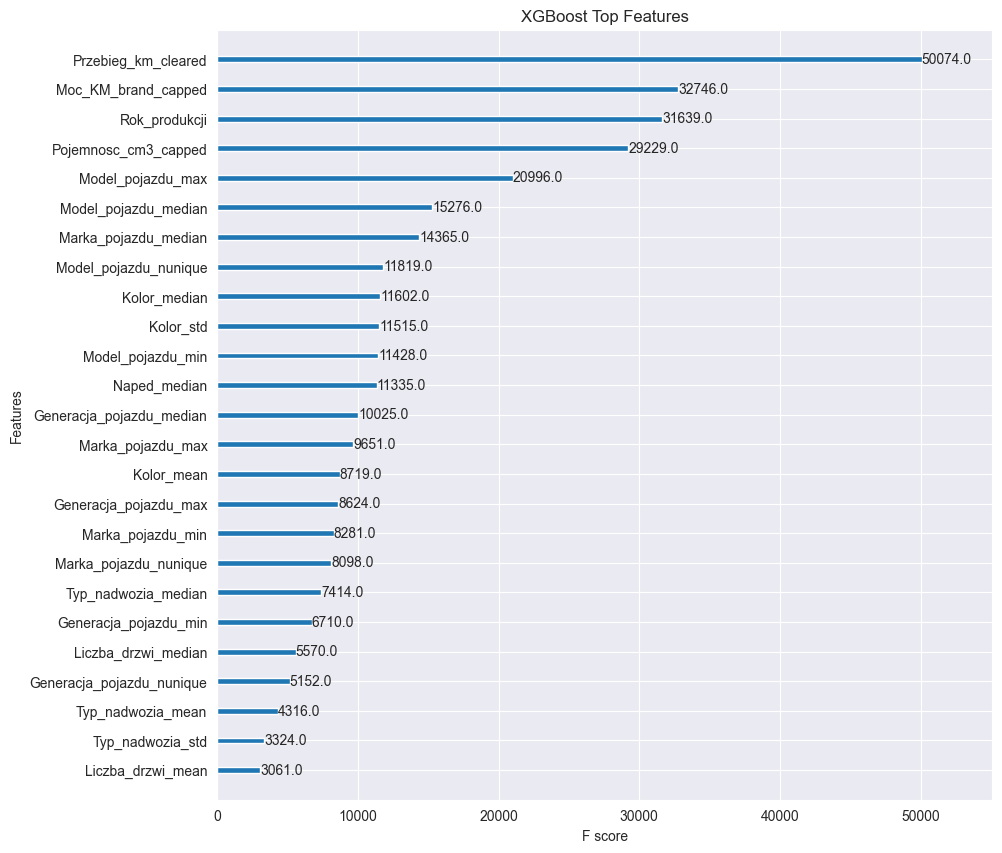

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(
    model,
    ax=ax,
    max_num_features=25,
    importance_type="weight", # 'gain', 'cover', 'total_gain', 'total_cover'
)
plt.title("XGBoost Top Features")
plt.show()

## Train the final model

In [38]:
# Create very small validation set for final training early stopping
modulo = 10
df.sort_values(by=target_column, inplace=True)  # Split randomly using modulo, but having even price distribution

test_mask = np.arange(len(df)) % modulo == 0
train_idx, test_idx = np.argwhere(~test_mask).flatten(), np.argwhere(test_mask).flatten()

y = df[target_column]

X_train, y_train = df.iloc[train_idx], y.iloc[train_idx]
X_test, y_test = df.iloc[test_idx], y.iloc[test_idx]

# Encode the categories
# and don't expose data information from validation to train (No data leakage)
all_features = deepcopy(features)
X_train, (X_test, X_submition) = target_encode(X_train.copy(deep=True), [X_test.copy(deep=True), df_submition.copy(deep=True)], all_features)
X_train, X_test, X_submition = X_train.loc[:, all_features], X_test.loc[:, all_features], X_submition.loc[:, all_features]

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train.to_numpy(), label=y_train, feature_names=all_features)
dtest = xgb.DMatrix(X_test.to_numpy(), label=y_test, feature_names=all_features)
# Train the model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=int(safe_num_of_estimators) + 500,     # To ensure there is no overfitting
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=50,
    verbose_eval=100
)

# Predict
dsub = xgb.DMatrix(X_submition.to_numpy(), feature_names=all_features)
predictions = model.predict(dsub)
print(f"Maximal prediction value detected : {predictions.max()}")
print(f"Maximal target in train : {y_train.max()}")
print(f"Maximal target in test : {y_test.max()}")

100%|██████████| 5/5 [00:00<00:00, 28.29it/s]


[0]	train-rmse:86096.69341	test-rmse:86220.88680
[100]	train-rmse:42287.47988	test-rmse:44214.38015
[200]	train-rmse:27142.43038	test-rmse:31437.06269
[300]	train-rmse:21935.77756	test-rmse:28036.54406
[400]	train-rmse:19748.74806	test-rmse:26856.45853
[500]	train-rmse:18546.45951	test-rmse:26255.69369
[600]	train-rmse:17808.58759	test-rmse:26001.99357
[700]	train-rmse:17306.71328	test-rmse:25788.21714
[800]	train-rmse:16920.02475	test-rmse:25622.96115
[900]	train-rmse:16594.18966	test-rmse:25513.71232
[1000]	train-rmse:16307.87959	test-rmse:25411.06731
[1100]	train-rmse:16027.56052	test-rmse:25335.82213
[1200]	train-rmse:15812.15810	test-rmse:25241.04409
[1300]	train-rmse:15591.37882	test-rmse:25199.69924
[1400]	train-rmse:15380.77267	test-rmse:25145.92554
[1500]	train-rmse:15193.49532	test-rmse:25080.37576
[1600]	train-rmse:15008.40414	test-rmse:25020.35739
[1700]	train-rmse:14829.47740	test-rmse:24965.29086
[1800]	train-rmse:14661.71319	test-rmse:24913.98326
[1850]	train-rmse:14583.

In [39]:
from utils.preprocessing import preprocess_currency

df_submit = df_test.copy(deep=True)
df_submit['Cena'] = predictions
df_submit = preprocess_currency(df_submit, invert=True)

df_submit.drop(columns=[col for col in df_test.columns if col not in ['ID', 'Cena']], inplace=True)
display(df_submit)
df_submit.to_csv('submission.csv', index=False)

Log: Amount of samples with foreign currency  : 99


,ID,Cena
0,1,199052.515625
1,2,19015.654297
2,3,21719.529297
3,4,99256.382812
4,5,90757.179688
...,...,...
72902,72903,100714.867188
72903,72904,32156.250000
72904,72905,57047.164062
72905,72906,24891.167969


In [41]:
df_test.loc[np.argsort(predictions)[-1]]

ID                                                                        56490
Waluta                                                                      PLN
Stan                                                                        New
Marka_pojazdu                                                       Rolls-Royce
Model_pojazdu                                                            Wraith
Wersja_pojazdu                                                              NaN
Generacja_pojazdu                                                           NaN
Rok_produkcji                                                              2019
Przebieg_km                                                                 2.0
Moc_KM                                                                    624.0
Pojemnosc_cm3                                                            6592.0
Rodzaj_paliwa                                                          Gasoline
Emisja_CO2                              

In [37]:
df_submit = df_test.copy(deep=True)
df_submit['Cena'] = predictions
df_submit = preprocess_currency(df_submit, invert=True)

mask = df_submit.Waluta == 'EUR'
print(predictions[mask][:10], df_submit.Cena[mask].to_numpy()[:10])

Log: Amount of samples with foreign currency  : 99


[ 88608.234  84345.62   58942.27   24008.604  78072.12  156927.69
  66738.62  157282.34    7651.754  34786.234] [20606.56613372 19615.25981105 13707.50454215  5583.39616642
 18156.30632267 36494.81104651 15520.60864826 36577.28924419
  1779.47765262  8089.82194767]


In [47]:
predictions[1]

19015.654